## Activity 04
### Tyler Barna

In [1]:
## import modules (running on python 3.9.12)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import nbinom
import random
random.seed(5731) ## set seed for reproducibility

## import data
df = pd.read_csv('Number_PNe.txt', sep='\s+')
df['N_PN'] = df['N_PN'].astype(int)

df.head()

,galaxy,N_PN
0,FCC083,63
1,FCC119,14
2,FCC143,13
3,FCC147,98
4,FCC148,58


Let's find some basic stats on the data set.


Number of galaxies: 21
Number of PNe: 1162
Max number of PNe in a galaxy: 159
Min number of PNe in a galaxy: 10
Mean number of PNe per galaxy: 55.3
Median number of PNe per galaxy: 45.0
Standard deviation of number of PNe per galaxy: 39.1


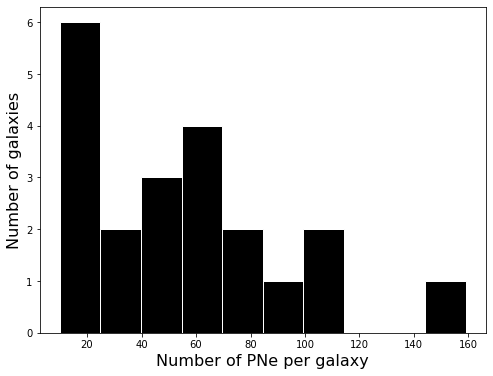

In [2]:
## find and print basic stats
print('Number of galaxies: %s'%df.shape[0])
print('Number of PNe: %s'%df['N_PN'].sum())
print('Max number of PNe in a galaxy: %s'%df['N_PN'].max())
print('Min number of PNe in a galaxy: %s'%df['N_PN'].min())
print('Mean number of PNe per galaxy: %s'%round(df['N_PN'].mean(),1))
print('Median number of PNe per galaxy: %s'%df['N_PN'].median())
print('Standard deviation of number of PNe per galaxy: %s'%round(df['N_PN'].std(),1))

## plot histogram of number of PNe per galaxy
fig, ax = plt.subplots(figsize=(8,6),facecolor='w')
ax.hist(df['N_PN'], color='k', edgecolor='w');
plt.xlabel('Number of PNe per galaxy', fontsize=16)
plt.ylabel('Number of galaxies', fontsize=16);
plt.show();

Our goal is to predict how many planetary nebulae we would expect to see in a given galaxy. I will first develop the standard prior and posterior models that we have developed in prior activities before doing a prior predictive check to estimate the number of planetary nebulae. In this case, we will be using a beta distribution for the prior and a beta distribution for the posterior. The *likelihood* will actually be the negative binomial distribution.

First, we'll do the prior:

$$\begin{equation}
\theta \sim \text{Beta}(b, c)
\end{equation}$$

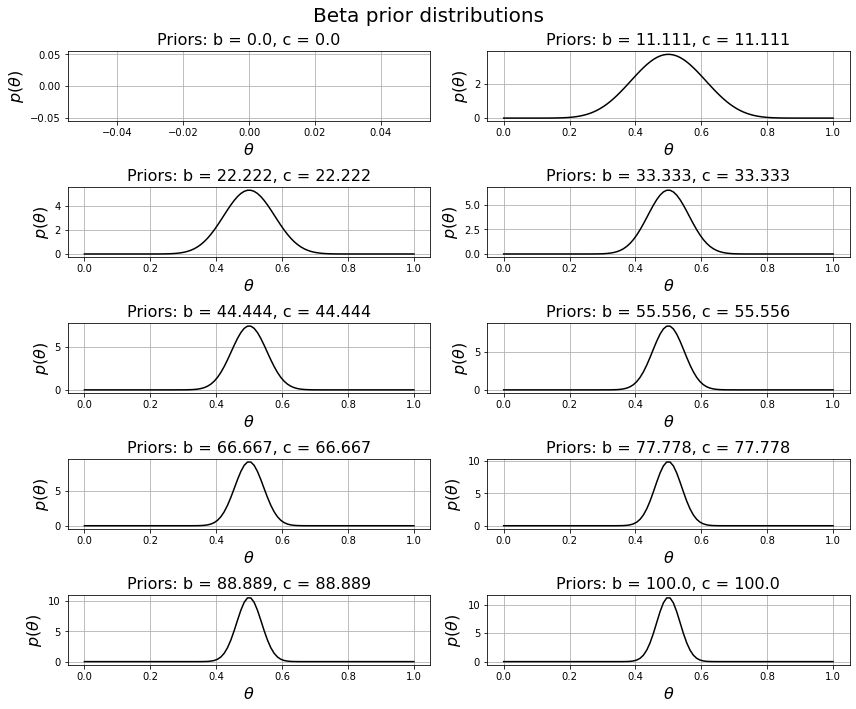

In [3]:
## develop beta prior distribution
n_priors = 10
b,c = np.linspace(0, 100, n_priors), np.linspace(0, 100, n_priors)

n_space = 1
x = np.linspace(0,n_space,n_space*100)
y = lambda b,c: beta.pdf(x,b,c)

## plotting
fig, axs = plt.subplots(int(n_priors/2), 2, facecolor='w',figsize=(12,n_priors))
fig.set_tight_layout(True)
idx = 0

for b,c in zip(b,c):
    ax = axs.flatten()[idx]
    ax.plot(x,y(b,c), color='k');
    ax.set_title('Priors: b = %s, c = %s'%(round(b,3),round(c,3)), fontsize=16)
    ax.grid()
    ax.set_xlabel(r'$\theta$', fontsize=16)
    ax.set_ylabel(r'$p(\theta)$', fontsize=16)
    idx+=1
fig.suptitle('Beta prior distributions', fontsize=20);


These are parallel, so it might be good to also try it with a random distribution of priors

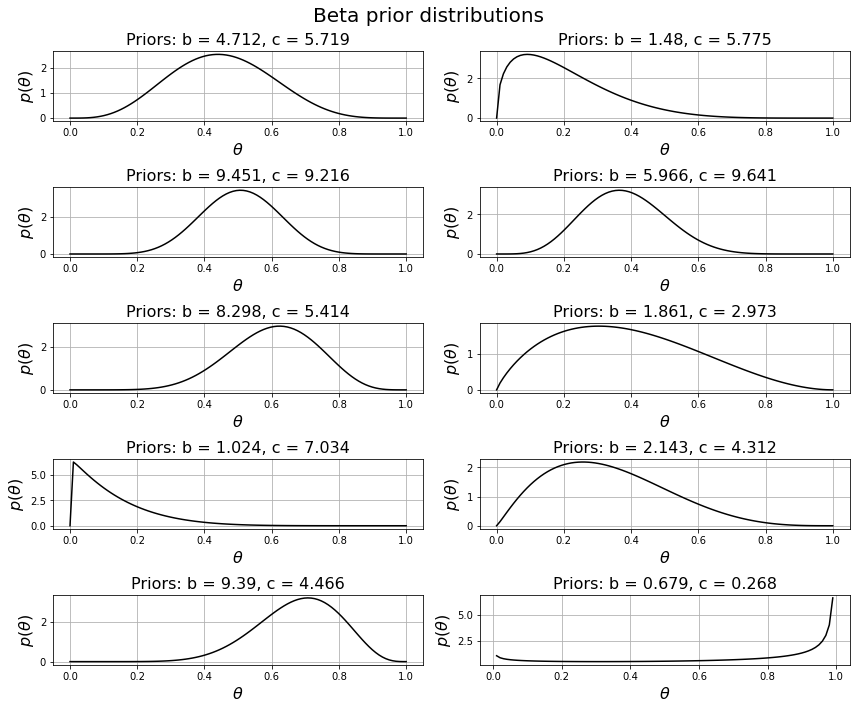

In [4]:
n_priors = 10
max_prior = 10
b,c = np.random.random(n_priors)*max_prior, np.random.random(n_priors)*max_prior

n_space = 1
x = np.linspace(0,n_space,n_space*100)
y = lambda b,c: beta.pdf(x,b,c)

## plotting
fig, axs = plt.subplots(int(n_priors/2), 2, facecolor='w',figsize=(12,n_priors))
fig.set_tight_layout(True)
idx = 0

for b,c in zip(b,c):
    ax = axs.flatten()[idx]
    ax.plot(x,y(b,c), color='k');
    ax.set_title('Priors: b = %s, c = %s'%(round(b,3),round(c,3)), fontsize=16)
    ax.grid()
    ax.set_xlabel(r'$\theta$', fontsize=16)
    ax.set_ylabel(r'$p(\theta)$', fontsize=16)
    idx+=1
fig.suptitle('Beta prior distributions', fontsize=20);

It's hard to make a judgement call on what the prior should be, so let's move onto the posterior for now. The posterior is also a beta distribution

$$\begin{equation}
\text{Posterior} \sim \text{Beta}\left( n a +b, \ n \bar{x} +c \right)
\end{equation}$$

where $n$ is the number of galaxies in the sample and $\bar{x}$ is the average number of planetary nebulae per galaxy in the sample.

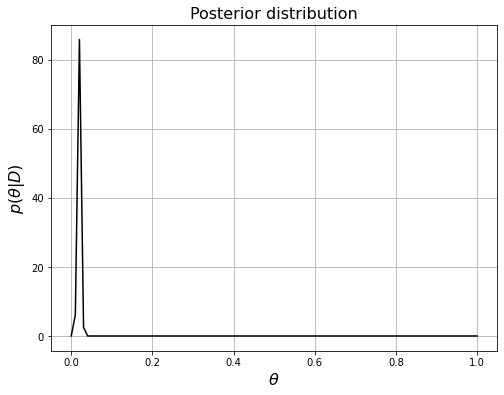

In [8]:
## create function to calculate posterior distribution
def posterior(df, abc):
    x = np.linspace(0,1,100)
    a,b,c = abc
    n = df.shape[0]
    post_a = n*a + b
    post_b = n*df['N_PN'].mean() + c
    post = beta.pdf(x,post_a,post_b)
    return post

def plot_post(df, abc=[1,1,1]):
    x = np.linspace(0,1,100)
    post = posterior(df, abc)
    fig, ax = plt.subplots(figsize=(8,6),facecolor='w')
    ax.plot(x,post, color='k');
    ax.set_title('Posterior distribution', fontsize=16)
    ax.grid()
    ax.set_xlabel(r'$\theta$', fontsize=16)
    ax.set_ylabel(r'$p(\theta|D)$', fontsize=16)
    return fig, ax

plot_post(df);